In [82]:
! pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import (silhouette_score,
                             accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay
                             )

import scipy.cluster.hierarchy as shc


import warnings
warnings.filterwarnings('ignore')

In [84]:
data = pd.read_excel("Online Retail.xlsx")
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [85]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [86]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [87]:
data.columns.to_list()

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [88]:
data.dropna(subset=['CustomerID'], inplace=True)
data = data[data['Quantity'] > 0]
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Applying RFM Model

In [89]:
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days = 1)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #Recency
    'InvoiceNo': 'nunique', # Frequency
    'TotalPrice': 'sum' # Monetary Value
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)
rfm.head()



,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [90]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397924.0,13.021823,1.0,2.0,6.0,12.0,80995.0,180.42021
InvoiceDate,397924,2011-07-10 23:43:36.912475648,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
UnitPrice,397924.0,3.116174,0.0,1.25,1.95,3.75,8142.75,22.096788
CustomerID,397924.0,15294.315171,12346.0,13969.0,15159.0,16795.0,18287.0,1713.169877
TotalPrice,397924.0,22.394749,0.0,4.68,11.8,19.8,168469.6,309.055588


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [92]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [93]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Finding a K by Elbov Method

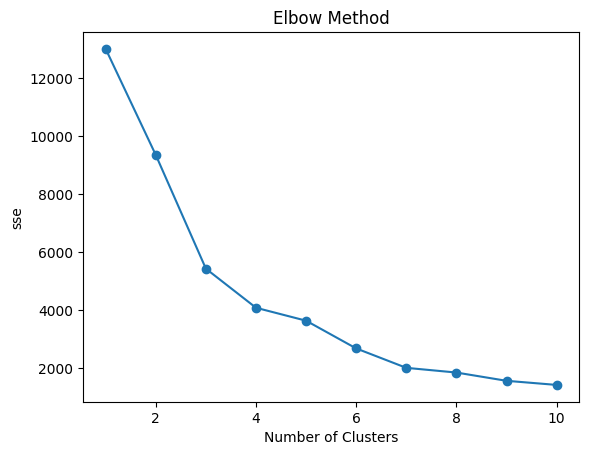

In [94]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("sse")
plt.show()

# DEndogram

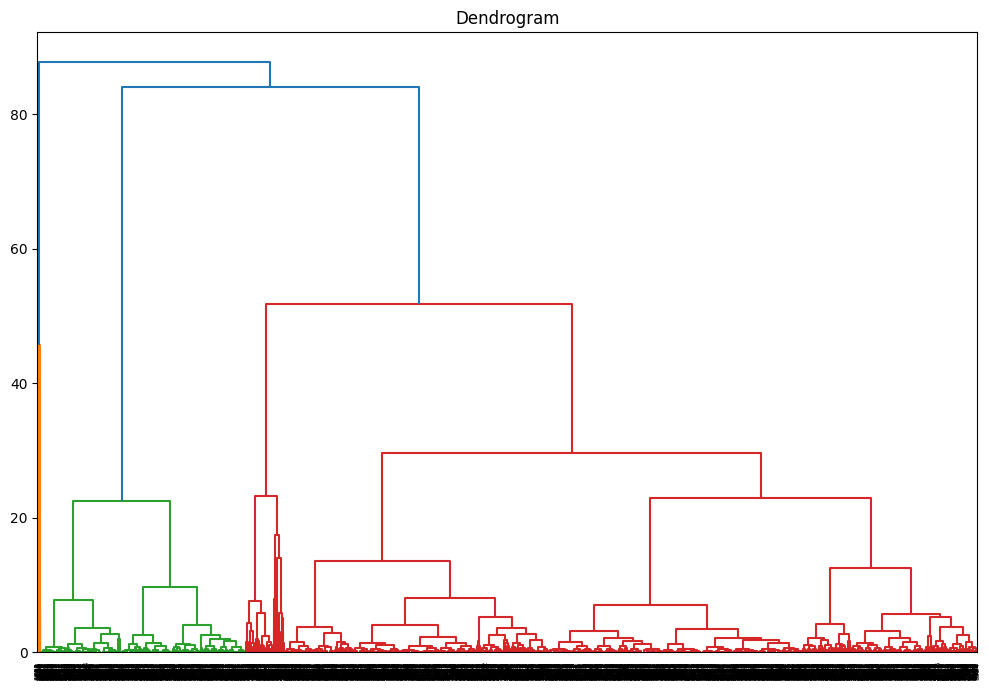

In [95]:
plt.figure(figsize=(10,7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(rfm_scaled,method="ward"))
plt.tight_layout()
plt.show()

# Applying all clustering model

* Kmeans

In [96]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)
kmeans_score = silhouette_score(rfm_scaled, kmeans_labels)
kmeans_score*100

61.611448195172756

* Hirarchical

In [97]:
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_label = agg.fit_predict(rfm_scaled)
agg_score = silhouette_score( rfm_scaled, agg_label)
agg_score*100

61.51102413239919

* DBSCAN

In [98]:
db = DBSCAN(eps=0.5, min_samples=5)
db_label = db.fit_predict(rfm_scaled)
db_score = silhouette_score(rfm_scaled, db_label)
rfm['Cluster'] = db_label
db_score*100

83.87774492176094

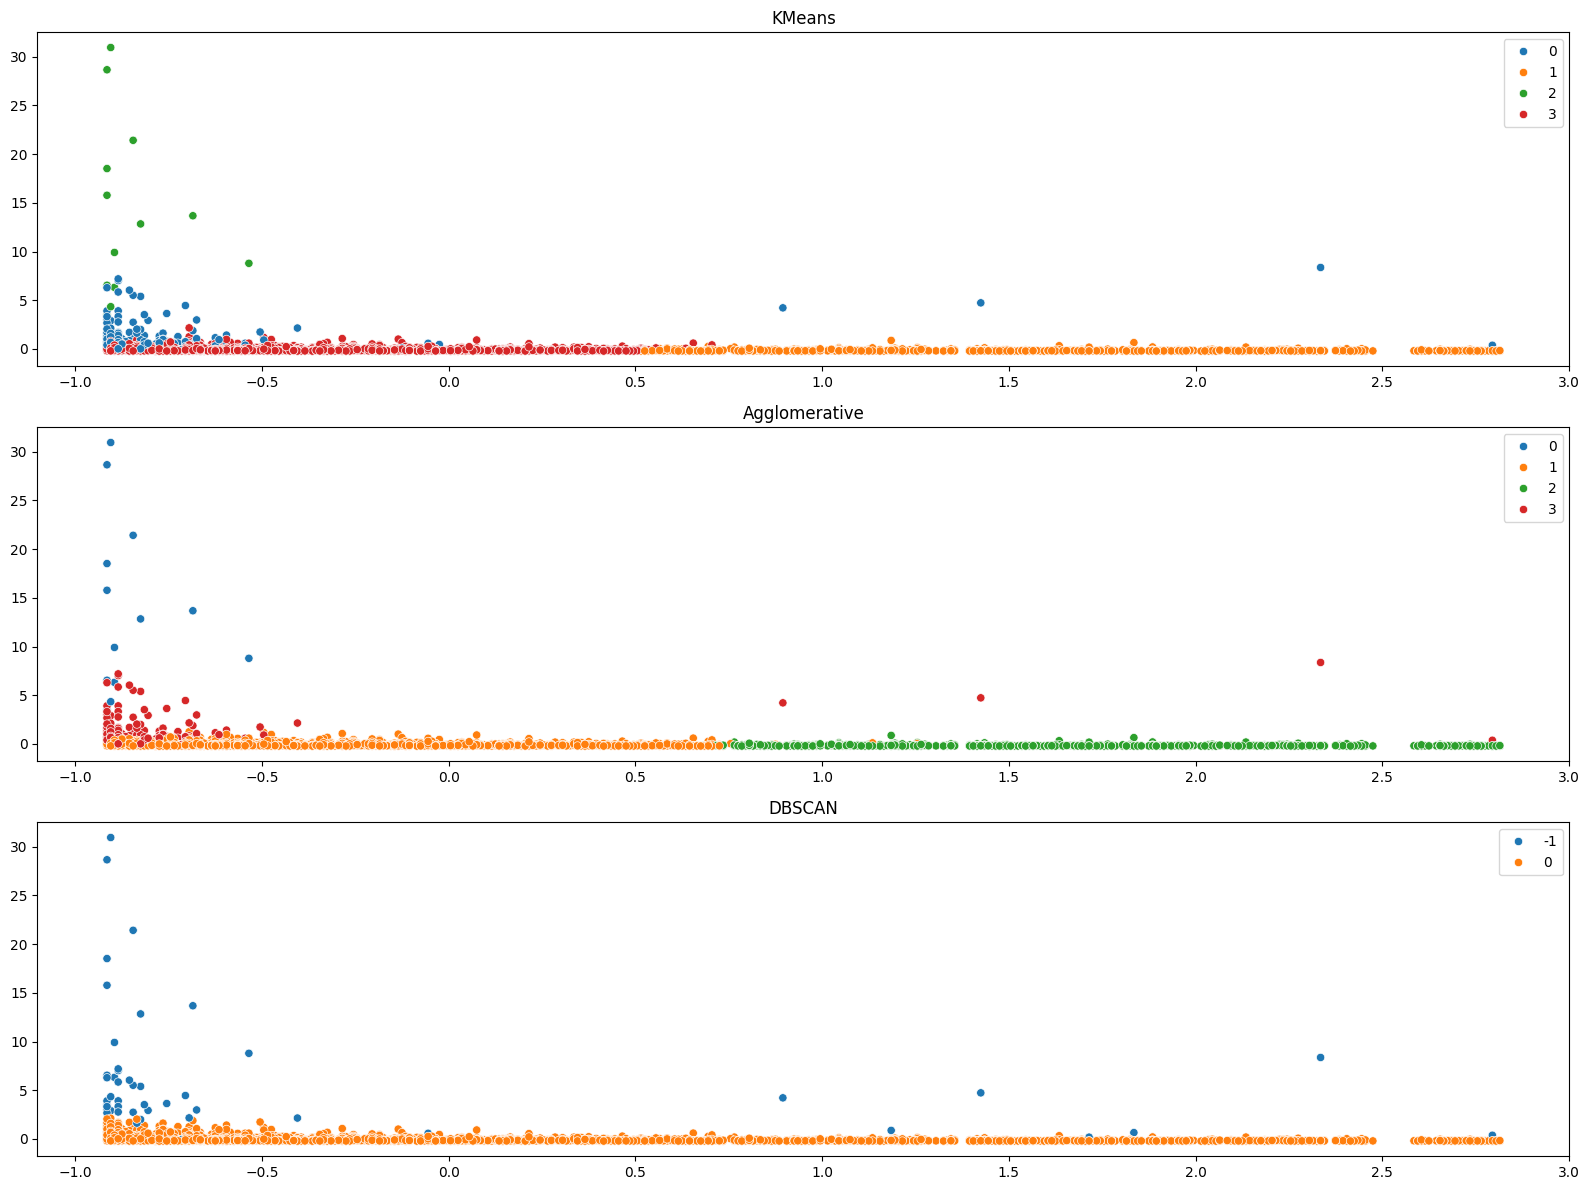

In [99]:
fig, axs = plt.subplots(3, figsize=(16, 12))
models = [('KMeans', kmeans_labels), ('Agglomerative', agg_label), 
          ('DBSCAN', db_label)]

for ax, (name, labels) in zip(axs.flat, models):
    sns.scatterplot(x=rfm_scaled[:,0], y=rfm_scaled[:,2], hue=labels, palette='tab10', ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()

# We can Clearly see that the score of dbscan is highest

# Applying Regression Model

In [100]:
x = rfm[['Recency','Frequency','MonetaryValue']]
y = rfm["Cluster"]

In [101]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [102]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42)
rf.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [103]:
y_pred = rf.predict(x_test)
y_pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [104]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.60      0.75        10
           0       1.00      1.00      1.00       858

    accuracy                           1.00       868
   macro avg       1.00      0.80      0.87       868
weighted avg       1.00      1.00      0.99       868



- Accuracy Score

In [105]:
accuracy_score(y_test,y_pred)*100

99.53917050691244